In [2]:
import numpy as np 
from matplotlib import pyplot as plt 
import scipy.io as sio
import torch 
import torch.nn as nn 
from torch.optim import SGD, Adam
from tqdm import tqdm

import cvxpy as cp 
from cvxpylayers.torch import CvxpyLayer


from utils import *
import generateData as gd 

In [3]:
n = 200
nSamples = 5000

M = 1
synthetic_data = gd.generateSynthData(d_list=[n], p=0.07, M=M, N=nSamples, dim_percent=0.8)

Number of Nodes: 200
Generating adj. matrices


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Sampling direct observations


100%|██████████| 1/1 [00:00<00:00, 25.63it/s]


Constructing the measurement matrix
changed scale
Generating the indirect measurements


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


Sensing matrix shape: (43, 200)


Text(0.5, 1.0, 'Baseline Sensing Matrix')

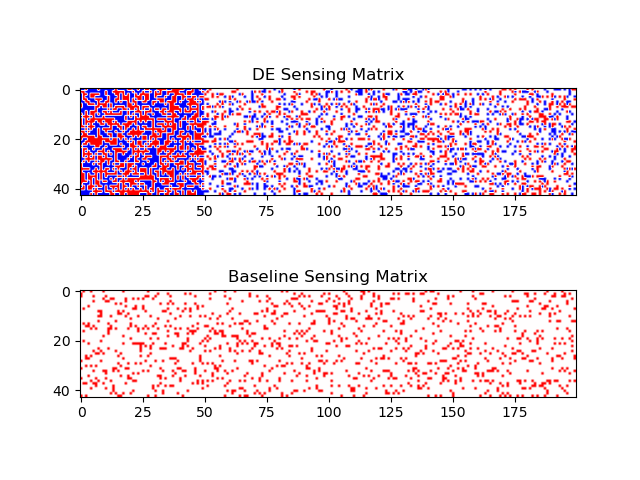

In [4]:
lambda_h = sio.loadmat("deg_pol_files/lambda_h_2.mat")['lambda_h']
lambda_l = sio.loadmat("deg_pol_files/lambda_l_2.mat")["lambda_l"]

A = getSensingMatrixUP(lambda_h, lambda_l, dch=50, dcl=50, nh=50, nl=150, A=1.0)
A_bs = generateA(A.shape[0], A.shape[1], delta=6)
print("Sensing matrix shape: {}".format(A.shape))

%matplotlib widget

fig, axs = plt.subplots(2, 1)

im = axs[0].imshow(A, cmap='bwr', vmin=-1, vmax=1)
axs[0].set_title("DE Sensing Matrix")
im = axs[1].imshow(A_bs, cmap='bwr', vmin=-1, vmax=1)
axs[1].set_title("Baseline Sensing Matrix")

In [5]:
nl = 150
nh = 50

X = synthetic_data[n]['X'][0]
W = synthetic_data[n]['W'][0]

Cov_X = np.linalg.inv(np.eye(n) - W.T) @ np.linalg.inv(np.eye(n) - W.T).T 

In [6]:
Y_bs = X @ A_bs.T
Sig_Y_bs = (1/Y_bs.shape[0]) * Y_bs.T @ Y_bs

In [7]:
def covarianceEstimateTorch(A, Sig_Y, pen_coeff=0.5):

    Sigma_hat = cp.Parameter(Sig_Y.shape)

    m, n = A.shape

    xhat = cp.Variable((n,n), PSD=True)
    objective = cp.Minimize(cp.sum(cp.abs(xhat)))
    constraints = [cp.norm(A @ xhat @ A.T - Sigma_hat)**2 <= pen_coeff]

    prob = cp.Problem(objective, constraints)
    assert prob.is_dpp()

    cvxpylayer = CvxpyLayer(prob, parameters=[Sigma_hat], variables=[xhat])
    # A_tch = torch.tensor(A_bs, requires_grad=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    Sig_tch = torch.tensor(Sig_Y, requires_grad=True, device=device)

    solution, = cvxpylayer(Sig_tch)

    Sig_est = (solution + solution.T)/2
    return solution.detach().cpu().numpy()


In [8]:
Y = X @ A.T 
Sig_Y = (1/Y.shape[0]) * Y.T @ Y

In [9]:
Cov_x_hat = covarianceEstimateTorch(A, Sig_Y)

In [11]:
Cov_x_hat = solution.detach().numpy()

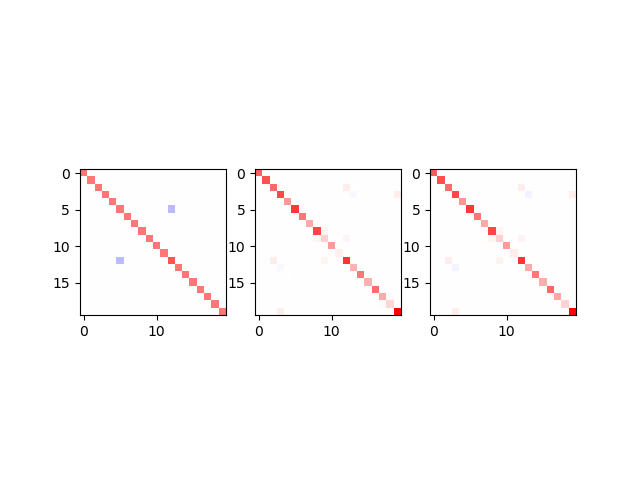

In [16]:
%matplotlib widget 

fig, axs = plt.subplots(1, 3)

max_val = max(np.abs(Cov_X[:20, :20]).max(), np.abs(Cov_x_hat[:20, :20]).max(), np.abs(Cov_x_hat_cvx[:20, :20]).max())

axs[0].imshow(Cov_X[:25, :25], vmin=-max_val, vmax=max_val, cmap='bwr')
axs[1].imshow(Cov_x_hat[:25, :25], vmin=-max_val, vmax=max_val, cmap='bwr')
axs[2].imshow(Cov_x_hat_cvx[:25, :25], vmin=-max_val, vmax=max_val, cmap='bwr')

In [8]:
Cov_x_hat_cvx = covarianceEstimate(Sig_Y, A, pen_coeff=0.5)